In [1]:
from pybaseball import playerid_lookup
from pybaseball import statcast_single_game,statcast_pitcher,pitching_stats_bref

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import requests
from bs4 import BeautifulSoup as BS
import re
import warnings
import folium
import bokeh
from numpy import NaN
import seaborn as sns
import prettyplotlib

from sklearn.linear_model import LinearRegression,ElasticNetCV,ARDRegression,Lasso, LogisticRegression
from sklearn.model_selection  import train_test_split,cross_val_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.svm import LinearSVC,SVC,OneClassSVM
from sklearn.exceptions import ConvergenceWarning

% matplotlib inline
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
all_starts = pd.read_csv('all_starts.csv',index_col=0)

all_starts.head()

,Player,Date,Tm,Opp,IP,H,R,ER,BB,SO,HR,UER,Pit,Str,GSc,BF,AB,2B,3B,IBB,HBP,SH,SF,GDP,SB,CS,PO,BK,WP,ERA,WPA,aLI,Appearance,Decision,Result,Score,date_length,Month,Year,number_of_apps,standard_dev,Quality_start,Str_Ratio,H/IP,SO/IP,BB/IP
0,John Lackey,2006-09-28,LAA,OAK,8.0,4,0,0,0,11,0,0,108.0,71.0,85,28,28,0,0,0,0,0,0,0,1,0,0,0,1,0.0,0.551,1.056,GS-8,W,W,2-0,10,9,2006,329,17.349702,1,0.657407,0.500000,1.375000,0.000000
1,John Lackey,2006-07-14,LAA,TBD,9.0,5,0,0,2,10,0,0,107.0,74.0,85,31,28,0,0,0,0,1,0,4,2,0,0,0,0,0.0,0.489,1.005,SHO,W,W,4-0,10,7,2006,329,17.349702,1,0.691589,0.555556,1.111111,0.222222
2,John Lackey,2006-07-07,LAA,OAK,9.0,1,0,0,0,10,0,0,109.0,77.0,95,28,28,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.500,0.781,SHO,W,W,3-0,10,7,2006,329,17.349702,1,0.706422,0.111111,1.111111,0.000000
3,John Lackey,2006-07-02,LAA,LAD,6.2,4,0,0,1,10,0,0,108.0,70.0,75,25,24,1,0,0,0,0,0,0,1,0,0,0,0,0.0,0.372,0.867,GS-7,W,W,4-0,10,7,2006,329,17.349702,1,0.648148,0.645161,1.612903,0.161290
4,Ervin Santana,2006-04-24,LAA,DET,6.0,5,0,0,2,10,0,0,111.0,65.0,70,25,22,1,0,0,1,0,0,0,0,1,0,0,0,0.0,0.381,1.205,GS-6,W,W,3-0,10,4,2006,358,17.270086,1,0.585586,0.833333,1.666667,0.333333


In [8]:
full_quality = pd.read_csv('full_quality.csv',index_col=0)

full_quality.head()

,Unnamed: 0.1,Player,Date,Tm,Opp,IP,H,R,ER,BB,SO,HR,UER,Pit,Str,GSc,IR,IS,BF,AB,2B,3B,IBB,HBP,SH,SF,GDP,SB,CS,PO,BK,WP,ERA,WPA,RE24,aLI,DFS(DK),DFS(FD),Appearance,Decision,Result,Score,Month,Year
0,0,Ervin Santana,2006-09-29,LAA,OAK,7.0,3,0,0,3,2,0,0,97,61,70.0,NaN,NaN,25,22,0,0,0,0,0,0,1,0,1,1,0,0,0.00,0.277,3.868,0.645,NaN,NaN,GS-7,W,W,6-0,9,2006
1,1,John Lackey,2006-09-28,LAA,OAK,8.0,4,0,0,0,11,0,0,108,71,85.0,NaN,NaN,28,28,0,0,0,0,0,0,0,1,0,0,0,1,0.00,0.551,4.421,1.056,NaN,NaN,GS-8,W,W,2-0,9,2006
2,2,Joe Saunders,2006-09-25,LAA,TEX,7.0,6,2,2,0,4,0,0,97,64,61.0,NaN,NaN,26,25,1,0,0,0,0,1,2,0,0,0,0,1,2.57,0.128,1.868,0.826,NaN,NaN,GS-7,W,W,8-3,9,2006
3,3,Ervin Santana,2006-09-24,LAA,OAK,8.0,2,1,1,2,2,0,0,97,59,74.0,NaN,NaN,28,25,0,1,0,1,0,0,2,0,0,0,0,0,1.12,0.295,3.286,0.668,NaN,NaN,GS-8,W,W,7-1,9,2006
4,4,John Lackey,2006-09-23,LAA,OAK,7.0,4,2,2,2,5,0,0,124,81,64.0,NaN,NaN,27,24,1,0,0,0,1,0,0,0,0,0,0,0,2.57,0.113,1.751,1.020,NaN,NaN,GS-7,W,W,6-2,9,2006


In [9]:
all_starts.loc[(all_starts.standard_dev.isna())]

all_starts = all_starts.dropna(subset=['Pit', 'Str','WPA','standard_dev']) 

all_starts.isna().sum()

len(all_starts)

all_starts.head()

,Player,Date,Tm,Opp,IP,H,R,ER,BB,SO,HR,UER,Pit,Str,GSc,BF,AB,2B,3B,IBB,HBP,SH,SF,GDP,SB,CS,PO,BK,WP,ERA,WPA,aLI,Appearance,Decision,Result,Score,date_length,Month,Year,number_of_apps,standard_dev,Quality_start,Str_Ratio,H/IP,SO/IP,BB/IP
0,John Lackey,2006-09-28,LAA,OAK,8.0,4,0,0,0,11,0,0,108.0,71.0,85,28,28,0,0,0,0,0,0,0,1,0,0,0,1,0.0,0.551,1.056,GS-8,W,W,2-0,10,9,2006,329,17.349702,1,0.657407,0.500000,1.375000,0.000000
1,John Lackey,2006-07-14,LAA,TBD,9.0,5,0,0,2,10,0,0,107.0,74.0,85,31,28,0,0,0,0,1,0,4,2,0,0,0,0,0.0,0.489,1.005,SHO,W,W,4-0,10,7,2006,329,17.349702,1,0.691589,0.555556,1.111111,0.222222
2,John Lackey,2006-07-07,LAA,OAK,9.0,1,0,0,0,10,0,0,109.0,77.0,95,28,28,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.500,0.781,SHO,W,W,3-0,10,7,2006,329,17.349702,1,0.706422,0.111111,1.111111,0.000000
3,John Lackey,2006-07-02,LAA,LAD,6.2,4,0,0,1,10,0,0,108.0,70.0,75,25,24,1,0,0,0,0,0,0,1,0,0,0,0,0.0,0.372,0.867,GS-7,W,W,4-0,10,7,2006,329,17.349702,1,0.648148,0.645161,1.612903,0.161290
4,Ervin Santana,2006-04-24,LAA,DET,6.0,5,0,0,2,10,0,0,111.0,65.0,70,25,22,1,0,0,1,0,0,0,0,1,0,0,0,0.0,0.381,1.205,GS-6,W,W,3-0,10,4,2006,358,17.270086,1,0.585586,0.833333,1.666667,0.333333


In [19]:
max(all_starts.GSc)

104

In [20]:
cm = sns.light_palette("xkcd:light gold", as_cmap=True)

worst_game_score = all_starts.loc[all_starts.GSc == 104]

worst_game_score.style.background_gradient(cmap=cm)

,Player,Date,Tm,Opp,IP,H,R,ER,BB,SO,HR,UER,Pit,Str,GSc,BF,AB,2B,3B,IBB,HBP,SH,SF,GDP,SB,CS,PO,BK,WP,ERA,WPA,aLI,Appearance,Decision,Result,Score,date_length,Month,Year,number_of_apps,standard_dev,Quality_start,Str_Ratio,H/IP,SO/IP,BB/IP
46061,Max Scherzer,2015-10-03,WSN,NYM,9,0,0,0,0,17,0,0,109,80,104,28,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0.587,1.014,SHO,W,W,2-0,10,10,2015,329,16.9679,1,0.733945,0,1.88889,0


In [10]:
def f(row):
    if row['IP'] >= 6.0 and row['ER'] <= 3.0:
        return 1
    else:
        return 0
    
all_starts['Quality_start'] = all_starts.apply(f, axis=1)

all_starts.Quality_start.sum()

30944

In [11]:
all_starts = all_starts[(all_starts[['IP']] != 0).all(axis=1)]

In [12]:
all_starts['Str_Ratio'] = ((all_starts.Str) / (all_starts.Pit))

all_starts['H/IP'] = ((all_starts.H) / (all_starts.IP))

all_starts['SO/IP'] = ((all_starts.SO) / (all_starts.IP))

all_starts['BB/IP'] = ((all_starts.BB) / (all_starts.IP))

In [13]:
len(all_starts.loc[(all_starts.IP == 0)])

0

## Linear Regression Example

In [10]:
feature_cols = ['SB','BK','SH','WP','aLI','Str_Ratio','GSc','Month','BB/IP','SO/IP','H/IP']

In [11]:
#'standard_dev','GDP','WP','SH','GSc'

In [12]:
X = all_starts[feature_cols]
y = all_starts[['Quality_start']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.5, random_state = 42)

In [14]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)

print(linreg.intercept_)
print(linreg.coef_)

[-0.86242708]
[[ 0.00548403 -0.01322823  0.02843472  0.00921314  0.01937215  0.44378414
   0.02284123 -0.00465874 -0.01335838 -0.13981319  0.0320245 ]]


In [15]:
zip(feature_cols,linreg.coef_)

In [16]:
y_pred = linreg.predict(X_test)

y_pred


array([[ 0.52625784],
       [-0.02791988],
       [-0.01940673],
       ...,
       [ 0.79000149],
       [ 0.09014785],
       [ 0.64337128]])

In [17]:
print('MAE',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:',metrics.mean_squared_error(y_test,y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
#print('Variance score: %.2f' r2_score(y_test, y_pred)

MAE 0.281391214035871
MSE: 0.1115786698551934
RMSE: 0.3340339351850249


In [18]:
print('Accuracy of linear regression classifier on test set: {:.2f}'.format(linreg.score(X_test, y_test)))
#plt.scatter(X_test['GSc'], y_test, color='black')
#plt.plot(X_test['GSc'], y_pred, color='blue', linewidth=3)

Accuracy of linear regression classifier on test set: 0.55


## Logistic Regression

In [19]:
all_starts.head()

,Player,Date,Tm,Opp,IP,H,R,ER,BB,SO,HR,UER,Pit,Str,GSc,BF,AB,2B,3B,IBB,HBP,SH,SF,GDP,SB,CS,PO,BK,WP,ERA,WPA,aLI,Appearance,Decision,Result,Score,date_length,Month,Year,number_of_apps,standard_dev,Quality_start,Str_Ratio,H/IP,SO/IP,BB/IP
0,John Lackey,2006-09-28,LAA,OAK,8.0,4,0,0,0,11,0,0,108.0,71.0,85,28,28,0,0,0,0,0,0,0,1,0,0,0,1,0.0,0.551,1.056,GS-8,W,W,2-0,10,9,2006,330,17.327930,1,0.657407,0.500000,1.375000,0.000000
1,John Lackey,2006-07-14,LAA,TBD,9.0,5,0,0,2,10,0,0,107.0,74.0,85,31,28,0,0,0,0,1,0,4,2,0,0,0,0,0.0,0.489,1.005,SHO,W,W,4-0,10,7,2006,330,17.327930,1,0.691589,0.555556,1.111111,0.222222
2,John Lackey,2006-07-07,LAA,OAK,9.0,1,0,0,0,10,0,0,109.0,77.0,95,28,28,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.500,0.781,SHO,W,W,3-0,10,7,2006,330,17.327930,1,0.706422,0.111111,1.111111,0.000000
3,John Lackey,2006-07-02,LAA,LAD,6.2,4,0,0,1,10,0,0,108.0,70.0,75,25,24,1,0,0,0,0,0,0,1,0,0,0,0,0.0,0.372,0.867,GS-7,W,W,4-0,10,7,2006,330,17.327930,1,0.648148,0.645161,1.612903,0.161290
4,Ervin Santana,2006-04-24,LAA,DET,6.0,5,0,0,2,10,0,0,111.0,65.0,70,25,22,1,0,0,1,0,0,0,0,1,0,0,0,0.0,0.381,1.205,GS-6,W,W,3-0,10,4,2006,358,17.270086,1,0.585586,0.833333,1.666667,0.333333


In [20]:
all_starts['Quality_start'].value_counts()

0    32070
1    30944
Name: Quality_start, dtype: int64

''

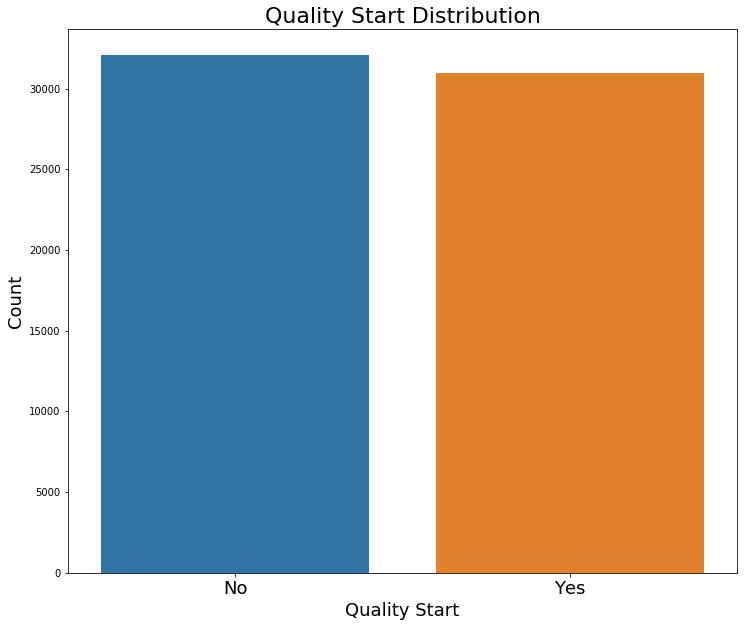

In [49]:

fig, ax = plt.subplots(figsize=(12,10))
ax = sns.countplot(x = 'Quality_start', data = all_starts)
ax.set_title('Quality Start Distribution',fontsize=22)
ax.set_ylabel('Count',fontsize=18)
ax.set_xlabel('Quality Start',fontsize=18)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Yes'
labels[0] = 'No'
ax.set_xticklabels(labels,fontsize=18)
#legend = ax.legend(('No','Yes'),title='Quality Start',fontsize=18, prop={'size': 20},loc=7)
#legend.get_title().set_fontsize('15')
;

In [24]:
count_no_sub = len(all_starts[all_starts['Quality_start']==0])
count_sub = len(all_starts[all_starts['Quality_start']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 50.89345224870664
percentage of subscription 49.10654775129336


In [25]:
all_starts.groupby('Quality_start').mean()

,IP,H,R,ER,BB,SO,HR,UER,Pit,Str,GSc,BF,AB,2B,3B,IBB,HBP,SH,SF,GDP,SB,CS,PO,BK,WP,ERA,WPA,aLI,date_length,Month,Year,number_of_apps,standard_dev,Str_Ratio,H/IP,SO/IP,BB/IP
Quality_start,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.673973,6.561740,4.237543,3.969504,2.137481,3.717399,0.940412,0.268039,87.927066,54.616745,38.320486,22.943655,20.182008,1.368319,0.150265,0.108793,0.228968,0.186966,0.204085,0.399938,0.405363,0.134300,0.041721,0.021547,0.206704,8.791145,-0.169308,0.968378,10.0,6.595198,2012.084596,145.413221,16.367992,0.620960,1.688953,0.821301,0.571725
1,6.743559,5.128167,1.664652,1.486007,1.681166,5.443737,0.458441,0.178645,100.729705,65.086156,63.068575,26.704305,24.531347,0.990208,0.090454,0.067671,0.193931,0.176319,0.118278,0.602734,0.323294,0.170437,0.050220,0.016417,0.162746,2.025890,0.166812,0.985600,10.0,6.516837,2011.911776,178.170889,16.599298,0.646784,0.774310,0.808946,0.257160


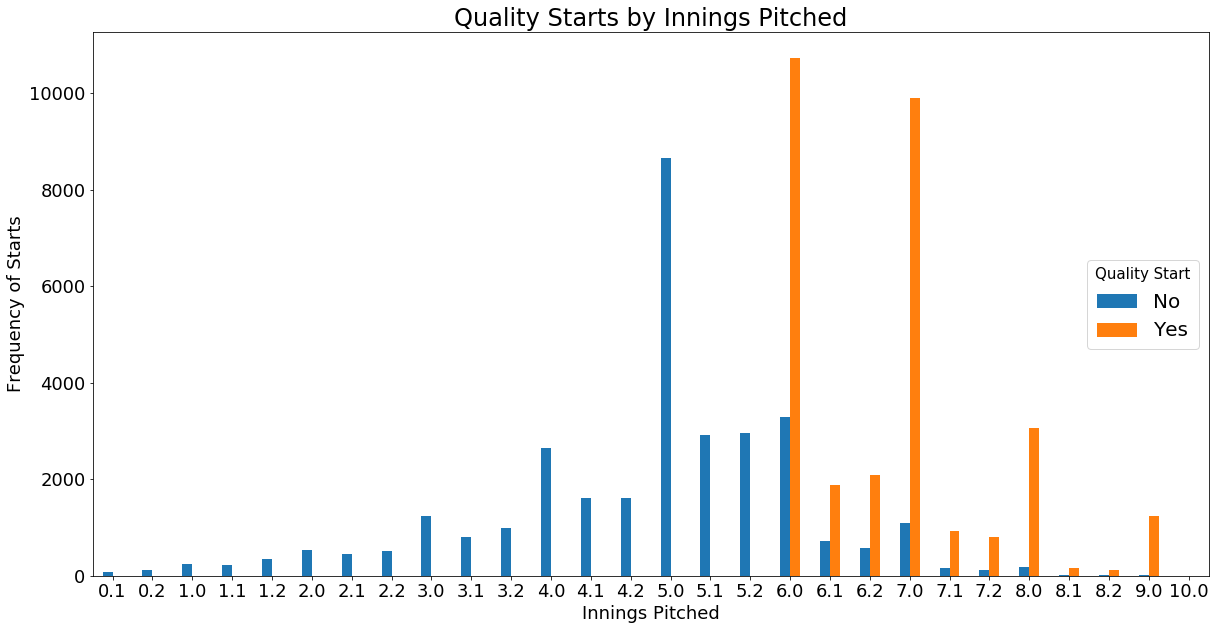

In [26]:
pd.crosstab(all_starts.IP,all_starts.Quality_start).plot(kind='bar',figsize=(20,10))
plt.title('Quality Starts by Innings Pitched',fontsize=24)
plt.xlabel('Innings Pitched',fontsize=18)
plt.xticks(fontsize=18,rotation=0)
plt.yticks(fontsize=18)
legend = plt.legend(('No','Yes'),title='Quality Start',fontsize=18, prop={'size': 20},loc=7)
legend.get_title().set_fontsize('15')
plt.ylabel('Frequency of Starts',fontsize=18)
plt.savefig('IP_QUAL_Chart.png')

In [27]:
grouped = all_starts.groupby(['Quality_start','GSc']).size().to_frame().reset_index()

grouped_2 = all_starts.groupby(['Quality_start','SO']).size().to_frame().reset_index()

grouped.columns = ['Quality_start','Game_score','Count']

grouped_2.columns = ['Quality_start','Strikeouts','Count']

In [28]:
grouped_2.head(10)

,Quality_start,Strikeouts,Count
0,0,0,1442
1,0,1,3484
2,0,2,5275
3,0,3,5803
4,0,4,5339
5,0,5,4363
6,0,6,2886
7,0,7,1770
8,0,8,962
9,0,9,436


In [29]:
grouped.Quality_start = grouped.Quality_start.astype(str)

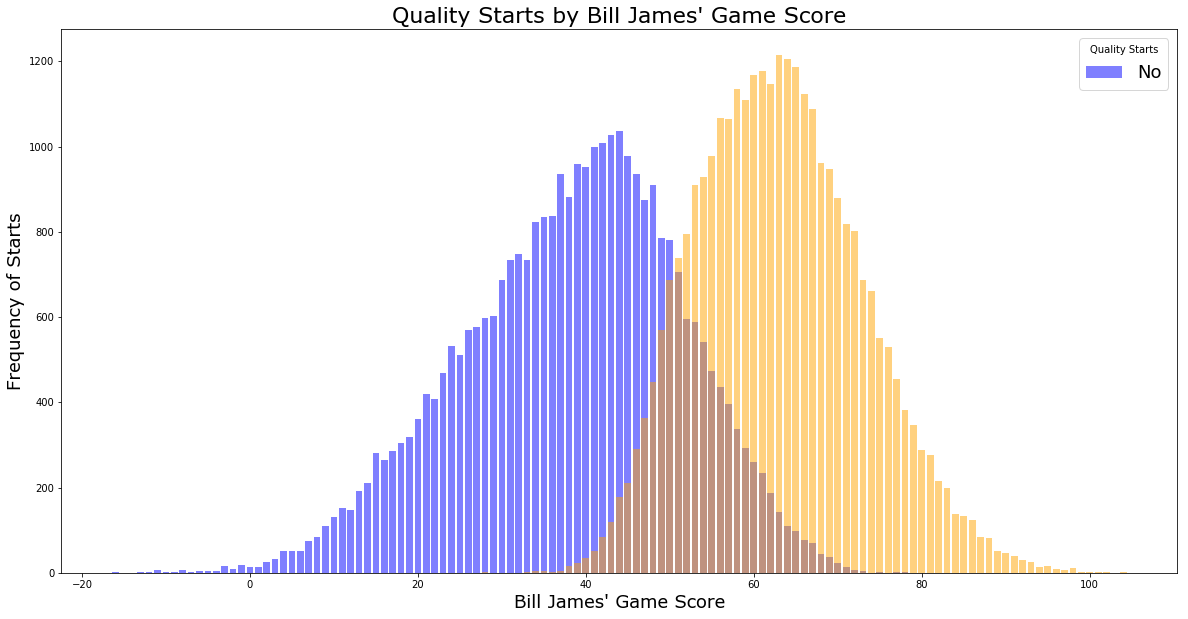

In [50]:
import matplotlib.lines as mlines

colors = {'0':'blue','1':'orange'}

fig,ax = plt.subplots(figsize=(20,10))
ax.bar(grouped.Game_score,height=grouped.Count,color=[colors[i] for i in grouped.Quality_start],alpha=0.5)
ax.set_title("Quality Starts by Bill James' Game Score",fontname='Verdana', fontsize=22)
ax.set_xlabel("Bill James' Game Score",fontname='Verdana', fontsize=18)
ax.legend(['No','Yes'],title='Quality Starts',fontsize=18)
for label in ax.xaxis.get_ticklabels()[::5]:
    label.set_visible(True)
ax.set_ylabel('Frequency of Starts',fontname='Verdana', fontsize=18);

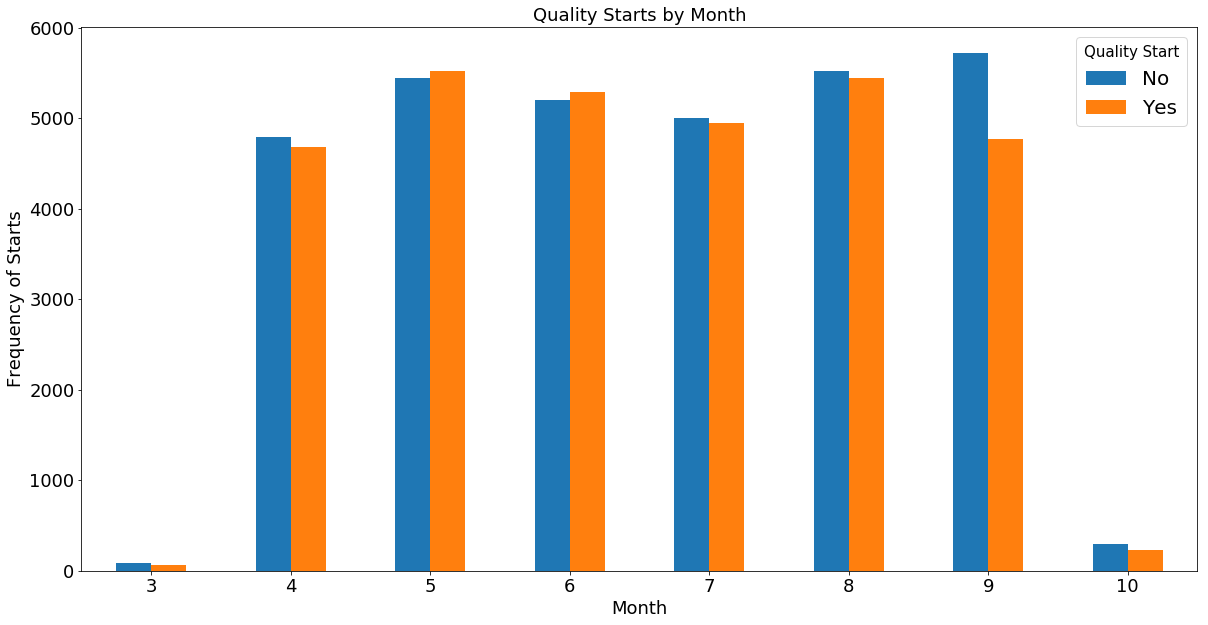

In [51]:
pd.crosstab(all_starts.Month,all_starts.Quality_start).plot(kind='bar',figsize=(20,10))
plt.title('Quality Starts by Month',fontsize=18)
plt.xticks(fontsize=18,rotation=0)
plt.yticks(fontsize=18)
plt.xlabel('Month',fontsize=18)
legend = plt.legend(('No','Yes'),title='Quality Start',fontsize=18, prop={'size': 20})
legend.get_title().set_fontsize('15')
plt.ylabel('Frequency of Starts',fontsize=18);

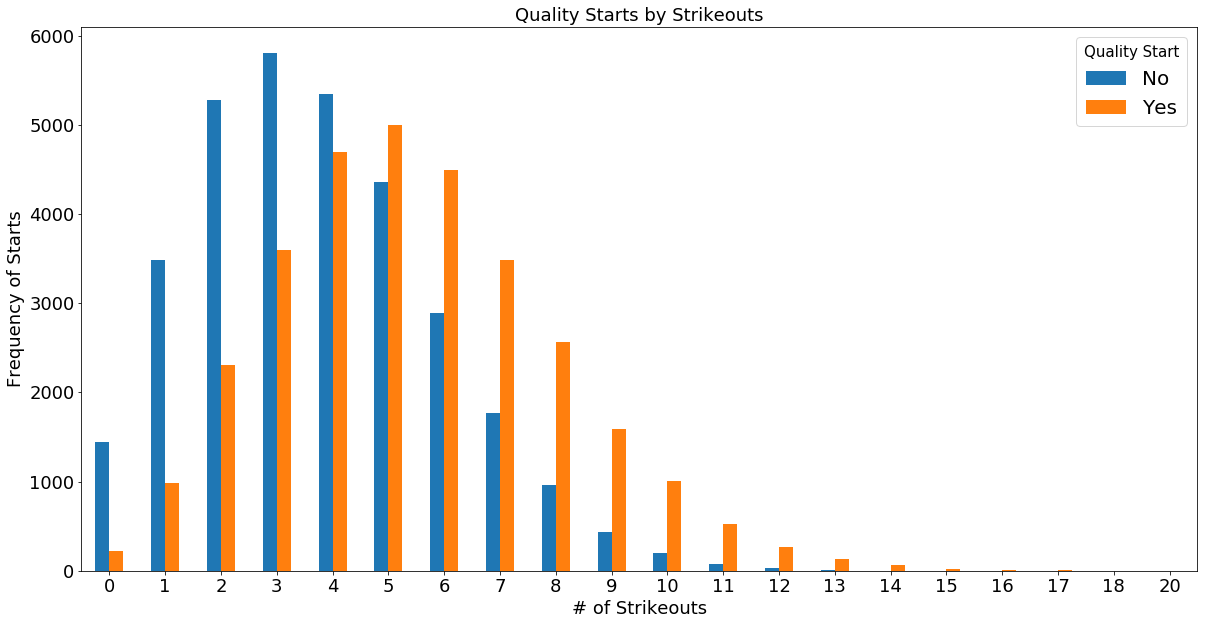

In [52]:
pd.crosstab(all_starts.SO,all_starts.Quality_start).plot(kind='bar',figsize=(20,10))
plt.title('Quality Starts by Strikeouts',fontsize=18)
plt.xlabel('# of Strikeouts',fontsize=18)
plt.xticks(fontsize=18,rotation=0)
plt.yticks(fontsize=18)
legend = plt.legend(('No','Yes'),title='Quality Start',fontsize=18, prop={'size': 20})
legend.get_title().set_fontsize('15')
plt.ylabel('Frequency of Starts',fontsize=18);

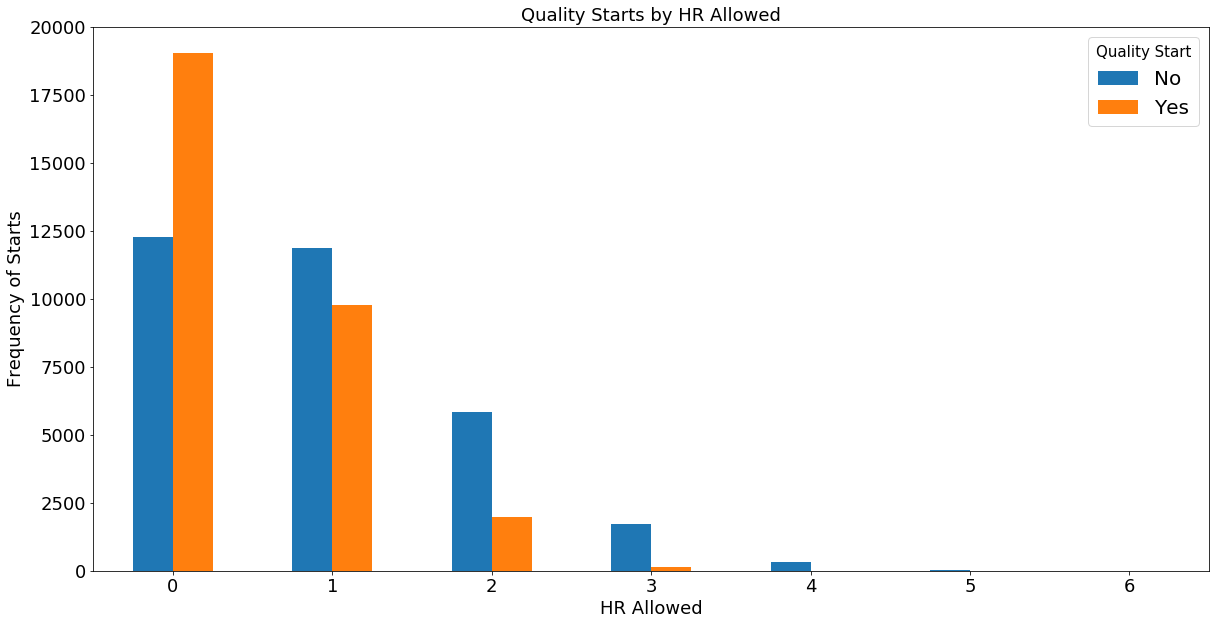

In [53]:
pd.crosstab(all_starts.HR,all_starts.Quality_start).plot(kind='bar',figsize=(20,10))
plt.title('Quality Starts by HR Allowed',fontsize=18)
plt.xlabel('HR Allowed',fontsize=18)
plt.xticks(fontsize=18,rotation=0)
plt.yticks(fontsize=18)
legend = plt.legend(('No','Yes'),title='Quality Start',fontsize=18, prop={'size': 20})
legend.get_title().set_fontsize('15')
plt.ylabel('Frequency of Starts',fontsize=18)
plt.savefig('IP_QUAL_Chart.png')

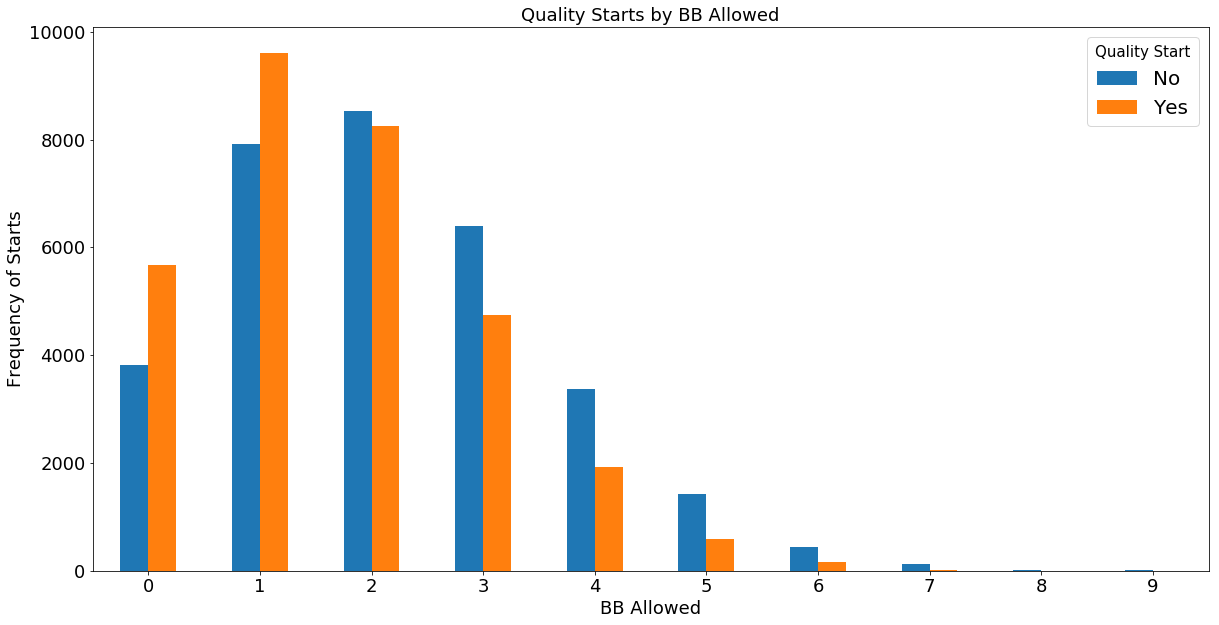

In [54]:
pd.crosstab(all_starts.BB,all_starts.Quality_start).plot(kind='bar',figsize=(20,10))
plt.title('Quality Starts by BB Allowed',fontsize=18)
plt.xlabel('BB Allowed',fontsize=18)
plt.xticks(fontsize=18,rotation=0)
plt.yticks(fontsize=18)
legend = plt.legend(('No','Yes'),title='Quality Start',fontsize=18, prop={'size': 20})
legend.get_title().set_fontsize('15')
plt.ylabel('Frequency of Starts',fontsize=18)
plt.savefig('IP_QUAL_Chart.png')

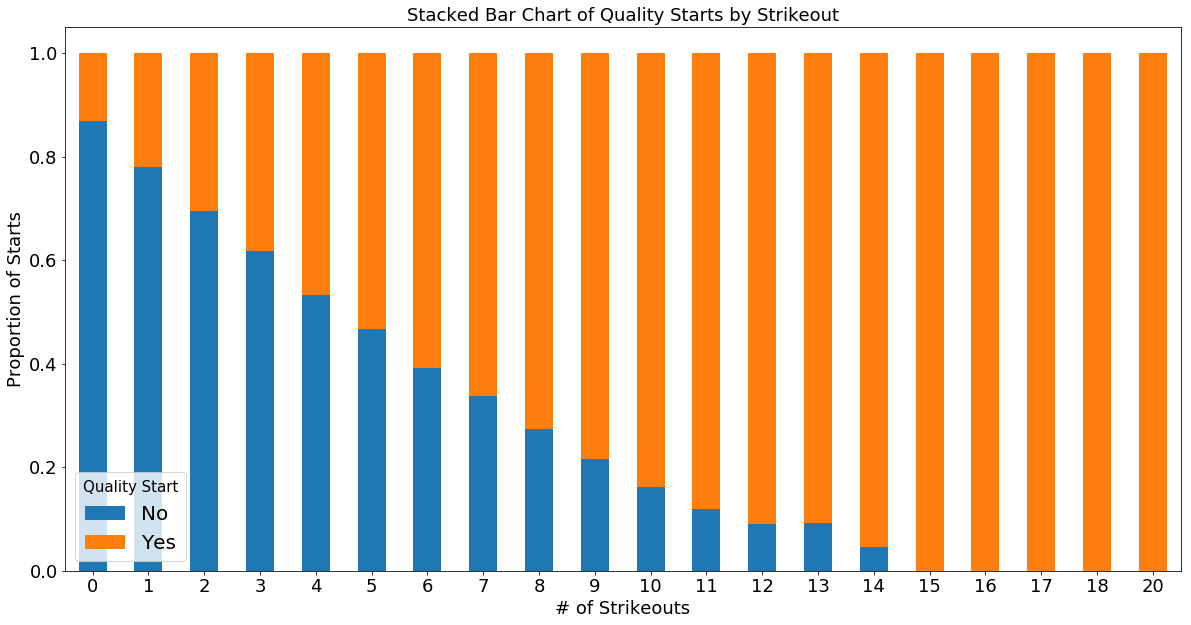

In [55]:
table=pd.crosstab(all_starts.SO,all_starts.Quality_start)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(20,10))
plt.title('Stacked Bar Chart of Quality Starts by Strikeout',fontsize=18)
legend = plt.legend(('No','Yes'),title='Quality Start',fontsize=18, prop={'size': 20},loc=3)
legend.get_title().set_fontsize('15')
plt.xlabel('# of Strikeouts',fontsize=18)
plt.xticks(fontsize=18,rotation=0)
plt.yticks(fontsize=18)
plt.ylabel('Proportion of Starts',fontsize=18)
plt.savefig('k_vs_qual.png')

In [56]:
cat_vars=['SO/IP','BB/IP','Str_Ratio','H/IP','HR','WPA','aLI','2B','SB','Quality_start']
all_starts_vars=all_starts.columns.values.tolist()
to_keep=[i for i in all_starts_vars if i in cat_vars]

In [57]:
#

In [58]:
all_starts_final=all_starts[to_keep]
all_starts_final.columns.values

array(['HR', '2B', 'SB', 'WPA', 'aLI', 'Quality_start', 'Str_Ratio',
       'H/IP', 'SO/IP', 'BB/IP'], dtype=object)

In [59]:
X = all_starts_final.loc[:, all_starts_final.columns != 'Quality_start']
y = all_starts_final.loc[:, all_starts_final.columns == 'Quality_start']


os = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train.values.ravel())
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Quality_start'])
# we can Check the numbers of our data
print("Length of oversampled data is:",len(os_data_X))
print("Number of poor starts in oversampled data:",len(os_data_y[os_data_y['Quality_start']==0]))
print("Number of quality starts:",len(os_data_y[os_data_y['Quality_start']==1]))
print("Proportion of poor starts in oversampled data is:",len(os_data_y[os_data_y['Quality_start']==0])/len(os_data_X))
print("Proportion of quality starts in oversampled data is:",len(os_data_y[os_data_y['Quality_start']==1])/len(os_data_X))





Length of oversampled data is: 44878
Number of poor starts in oversampled data: 22439
Number of quality starts: 22439
Proportion of poor starts in oversampled data is: 0.5
Proportion of quality starts in oversampled data is: 0.5


In [60]:
#all_starts_vars=all_starts_final.columns.values.tolist()

#X=[i for i in all_starts_vars if i not in y]
#y=['Quality_start']

#from sklearn.linear_model import LogisticRegression


#logreg = LogisticRegression()
#rfe = RFE(logreg, 20)
#rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
#print(rfe.support_)
#print(rfe.ranking_)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [62]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.85


In [63]:
confusion_matrix = confusion_matrix(y_test, y_pred)

In [64]:
print(classification_report(y_test, y_pred))
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12785
           1       0.84      0.85      0.85     12421

   micro avg       0.85      0.85      0.85     25206
   macro avg       0.85      0.85      0.85     25206
weighted avg       0.85      0.85      0.85     25206

[[10751  2034]
 [ 1805 10616]]


In [65]:
print(logreg.coef_)

[[-0.06022128  0.16156188  0.15191434  6.84231331  0.61567353  2.45836825
  -2.33804729 -0.55854944 -2.79664573]]


In [66]:
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

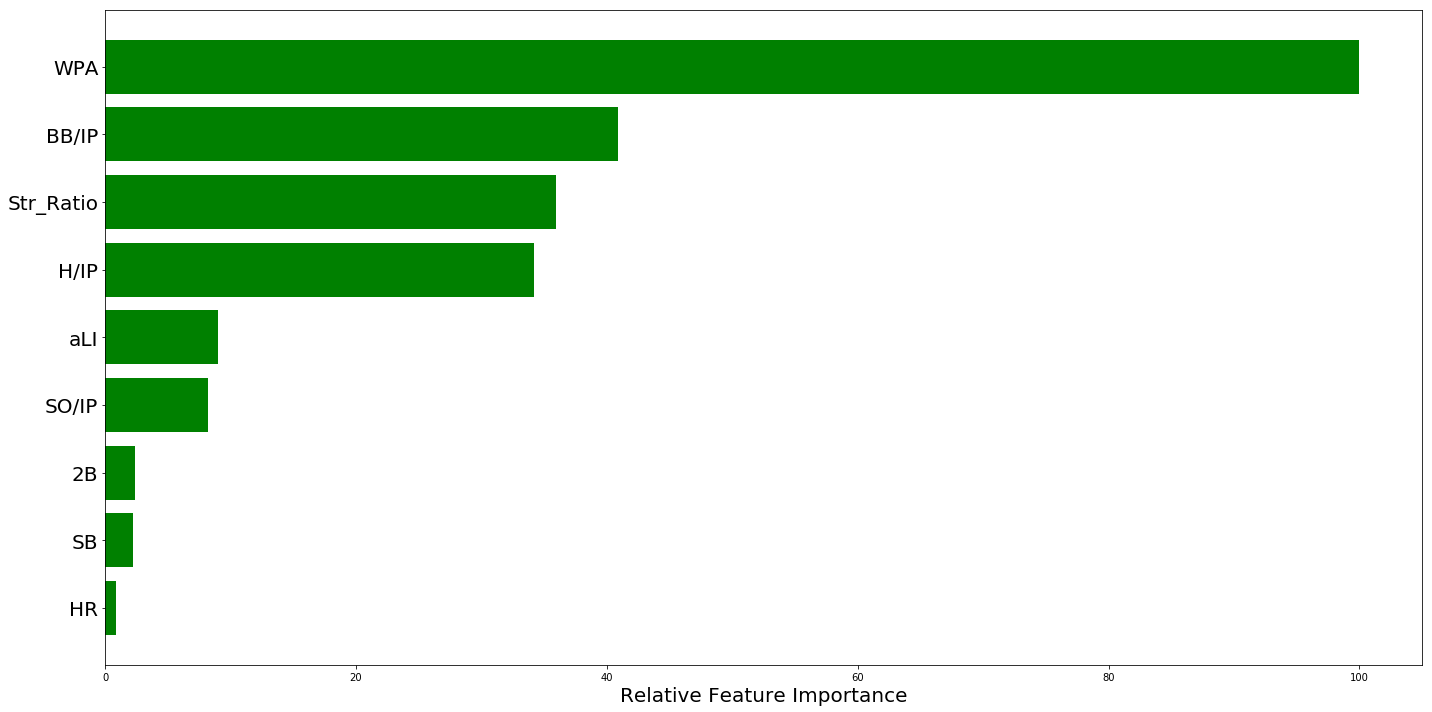

In [67]:
featfig = plt.figure(figsize=(20,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center',color='green')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=20)
featax.set_xlabel('Relative Feature Importance',fontsize=20)

plt.tight_layout()

''

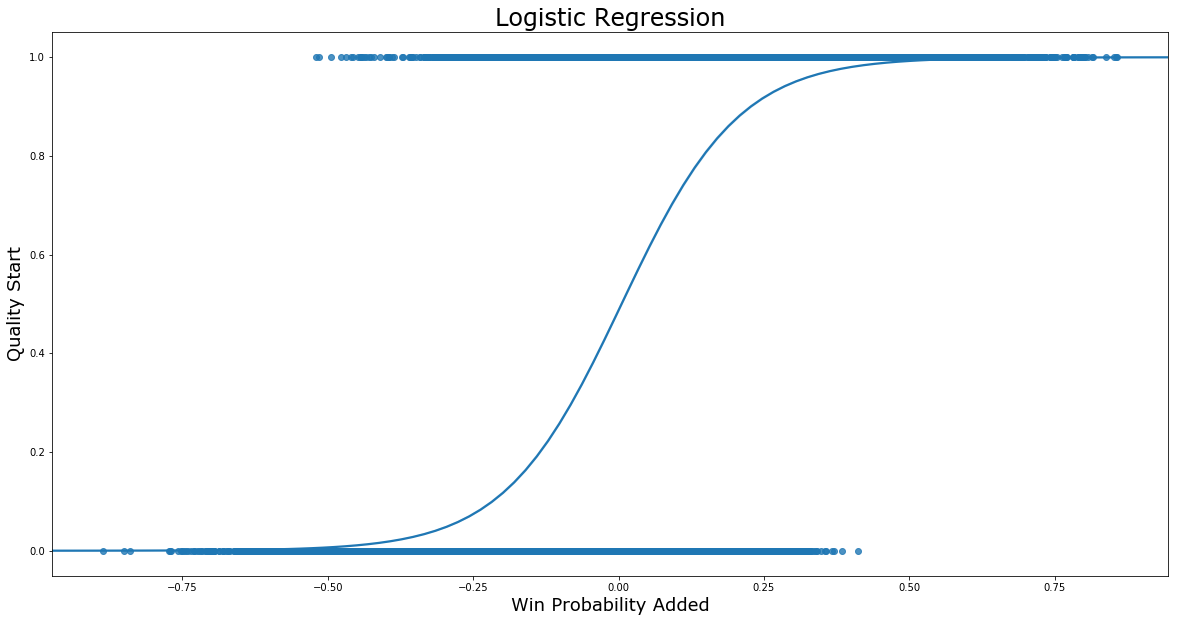

In [68]:
import seaborn as sns

ax = sns.regplot(x='WPA', y='Quality_start', data=all_starts_final, logistic=True)

ax.set_title("Logistic Regression",fontname='Verdana', fontsize=24)
ax.set_xlabel('Win Probability Added',fontname='Verdana', fontsize=18)
ax.set_ylabel('Quality Start',fontname='Verdana',fontsize=18)
ax.figure.set_size_inches(20, 10)
#ax.figure(figsize=(20,10))
;

In [ ]:
all_starts.to_csv('all_starts.csv')

## Linear SVC example

In [ ]:
clf = LinearSVC()

In [ ]:
clf.fit(X,y.values.ravel())

In [ ]:
clf.predict(X)